In [1]:
# Create pie charts representing the distribution of viable, reasonable, and situationally-relevant responses by condition
# Version: STARS paper (Jun 2023)
# Date: Jun 23
#
# Notes:
# Apr 23:
# Significantly reworked to resolve data integrity issues with simple join in previous version
#
# MAY 23
# Added outer shell to summarize four main categories (not viable, viable but not reasonable, viable and reasonable but not sit rel, sit rel)
# 
# Jun 23 (STARS)
# - Custom formats for odd number of conditions
# - Added by-object analysis chart
# - Added "at least reasonable" chart

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path

# Must set to this to path for your system
# Assumes there is a experiment_name directory at this path with subdirectory raw_data and output
# (If you are running on the data included in the repo, the substructure should be fine)
BASE_DIR = Path('/TODO/INSERT/PATH/TO/REPO/ROOT')

# Sanity check your specified path
assert BASE_DIR.is_dir(), "You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory."

os.chdir(BASE_DIR / 'DataAnalysisScripts' / 'ITLAgent-LogProcessingScripts')

AssertionError: You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory.

In [2]:
# Experiment specific variables
# experiment_name = "TidyKitchenTask"
# experiment_name = "GroceryTask"
experiment_name = "OfficeTask"
#experiment_name = "Verification-AtypicalObjects"
#condition_names = ["Planning", "Instruction", "Plan+LLM", "Inst+LLM", "Combined_d2", "Combined_d4"]
condition_names = ["Instruction", "Inst+Search", "Search+LLM", "Instruction+LLM", "Inst+Search_2+LLM", "Inst+Search_4+LLM"]
condition_names = ["lm_tree_repair_select_13Apr","duplicate_test_condition"]
condition_names = ["lm_tree_repair_select18Apr","duplicate_test_condition"]
condition_names = ["lm_human","lm_human_tree","lm_human_tree_eval","lm_human_tree_select","lm_human_tree_eval_select","lm","lm_tree","lm_tree_eval","lm_tree_select","lm_tree_eval_select"]
condition_names = ["lm_human","lm_human_tree_eval_select","lm","lm_tree","lm_tree_eval","lm_tree_select","lm_tree_eval_select"]
#condition_names = ["lm_human_tree_eval_select"]
condition_names = ["TBP","TBP+O","ST","STS","STAR","STARS","STARS+O"]

#condition_names = ["lm_human", "Rlm_tree_eval_select_run1", "Rlm_tree_eval_select_run2", "Rlm_tree_eval_select_run3","Rlm_tree_eval_select_run4", "Rlm_tree_eval_select_run5"]

#condition_names = ["lm_tree_eval_select", "extra_test_data","extra_test_data1","extra_test_data2"]

condition_names.reverse()
#condition_names = ["all_conditions_depth4"]

# gold_solutions = "gold-standard-canonical.txt"
gold_solutions = "gold.txt"
#gold_solutions = "gold-standard-30.txt"
# Change in the gold definition so that only destination for dirty items is dishwasher (sink allowed but check for special case in the match function)
#gold_solutions = "gold-standard-atypical.txt"

# Note that the data files are now organized differently for the IJCAI experiment, with the experiment at the root
output_directory =  "./" + experiment_name + "/output/"
data_path = "./" + experiment_name + "/raw_data/" 
goldpath = "./" + experiment_name + "/" + gold_solutions

if not Path(experiment_name).is_dir():
    raise ValueError(f"Experiment directory does not exist: {experiment_name}")
Path(output_directory).mkdir(exist_ok=True)
if not Path(data_path).is_dir():
    raise ValueError(f"Experiment raw data directory does not exist: {data_path}")
if not Path(goldpath).is_file():
    raise ValueError(f"Gold standard file does not exist: {goldpath}")

# Viability analysis files
viability_file = "viable.txt"
non_viability_file = "unviable.txt"
all_responses_file  = "retrieved.txt"
used_responses_file = "used_response.txt"

# Patterns for extraction from the response fields
goal_target_pattern = r'is in the (\w+)'
affordance_target_pattern = r'and the (\w+) is closed'


In [70]:
# Determine if the response.response matches the conditions specified in the gold
#
# Note that this is pretty brittle and assumes that the response is in the "the goal is that" form.
# Note that this function assumes handle/category identifiers have been stripped from location targets (like "garbage")
# Also returns whether the response was reasonable (or if not, what condition failed)
# (ie, the function name is now a bit of a misnomer; it's doing both gold and reasonable)

def match_gold_responses(description,obj,relation,target):

    debug=False
    #debug=True
    # Initialize a variable to keep track of whether a match was found
    match_found = False
    is_reasonable = False
    
    if debug==True:
        print(description)
        print(re.sub('-', ' ',description))
        print(obj,re.sub(r'(\d)*_instance_\d+', '', obj).replace('-', ' '))
        print("Relation: ", relation)
        print("Target:",target)
        
        #print(target, re.sub(r'\d+', '', target).replace('-', ' '))
    
    synonyms = { "trash":"garbage",
                 "bin":"recycling bin",
                 "refrigerator": "fridge",
                 "dish drainer": "rack",
                 "dishrack": "rack",
                 "dish rack": "rack"}
    
    
      
    # Items that must be closed as a completion step for the response to be situationally relevant
    closed_targets = ['fridge', 'drawer', 'cupboard', 'pantry', 'dishwasher']
    
    # If these targets are not closed, we will consider it "reasonable" to not have closed the door
    reasonably_unclosed_targets = ['cupboard', 'pantry', 'dishwasher']
    
    # Substitutions that could be reasonable if the agent had improved sensing 
    # Eg, "plate on table" could be dirty or clean in which case could go to dishwasher or cupboard
    accepted_substitutions_due_to_limited_embodiment = {"dishwasher":"cupboard",
                                            "sink":"cupboard",
                                            "garbage":"fridge",
                                            "bin":"fridge"}
    
    # A response is reasonable if gold indicates the key location but the agent put it in the value location
    reasonable_substitutions = {"pantry":"cupboard",
                          "cupboard":"pantry"}
    
      
    
    # Replace all the known synonyms for the specific words used in the old responses
    # REW: Brittle! Only allows one substitution per description
    for word, replacement in synonyms.items():
        if word in description:
            description = re.sub(word,replacement,description)
            if debug==True:
                print ("replacing", word, "with", replacement)
                print(description)
            break
           
    # Check if the object appears in the description (ignoring digits and dashes)
    if re.sub(r'(\d)*_instance_\d+', '', obj).replace('-', ' ') in re.sub('-', ' ',description):
        if debug==True:
            print(obj,"is in the description")
        # Check if the relation appears in the description
        if relation in description:
            # Check if the target appears in the description (ignoring digits and dashes)
            if debug:
                print (relation, "is in the description")
            if target in description:
                # If all three conditions are met, set match_found to True and exit the loop
                if debug:
                    print(target,"is in the description")
                
                # A match is only found when a closed target is closed
                if target in closed_targets:
                    if "closed" in description:
                        match_found = True
                    else:
                        match_found = False
                        if target in reasonably_unclosed_targets:
                            is_reasonable = "post-completion error"
                        else:
                            is_reasonable = "viable but not reasonable"
                else:
                    # If there is no closed target then we have found a match at this point
                    match_found = True
            elif (target=="dishwasher") and ("sink" in description):
                # If gold says dishwasher, the sink is also an acceptable location
                if debug:
                    print("Ok for ",obj,"to go to sink instead of dishwasher")
                match_found = True
            
            
            # Not a match to gold but can check for various reasonable outcomes
            # Brittle check here (target in keys must evaluate to true or else error)
            elif (target in reasonable_substitutions) and reasonable_substitutions.get(target) in description:
                # reasonable substitution
                reasonable_target = reasonable_substitutions.get(target)
                if debug:
                    print("Reasonable target for", target, "is", reasonable_target)
                if reasonable_target in closed_targets:
                    if "closed" in description:
                        is_reasonable = "reasonable alternative location"
                    else:
                        if reasonable_target in reasonably_unclosed_targets:
                            is_reasonable = "post-completion error"
                        else:
                            is_reasonable = "viable but not reasonable"
                else:
                    is_reasonable = True
            else:
                if (target in accepted_substitutions_due_to_limited_embodiment) and (accepted_substitutions_due_to_limited_embodiment.get(target) in description):
                    #Target not a reasonable substitution
                    is_reasonable = "embodiment limitation"
                else:
                    is_reasonable = "viable but not reasonable"
                    #print(description,obj,relation,target)
        else:
            # This is a case where the relation was not found in the description and we are thus
            # going to assume not SA and not reasonable
            is_reasonable = "viable but not reasonable"
            
                    
    # By definition, if it matches gold, then it is reasonable
    if match_found==True:
        is_reasonable = True

    return match_found, is_reasonable


In [71]:
# For testing the function
match_gold_responses("the goal is that the cup is in the sink","cup1_instance_46","in","dishwasher")

(True, True)

In [72]:
# Not updating for now but note that "reasonable" should now never be "True"

def categorize_response(failure_reason,viable,sent_to_robot,reasonable,relevant):
    category = "Uncategorized"
    
    if viable==False:
        category = failure_reason
    elif sent_to_robot==False:
        if relevant==True:
            category="situationally relevant"
        elif reasonable==True:
            category="reasonable"
        else:
            category=reasonable
    elif relevant==False:
        if reasonable==True:
            category="reasonable"
        else:
            category=reasonable
    else:
        category="situationally relevant"
    
    return category
  
    

In [73]:
# This is the main function to create an individual pie chart

def process_response_summary_data(ax, category_df, condition, offset):

    color_dict = {'uninterpretable': 'pink',
              'unknown-word': 'xkcd:faded pink',
              'ungrounded-object': 'lightpink',
              'affordance-mismatch': 'xkcd:light rose',
              'viable but not reasonable': 'xkcd:light peach',
              'embodiment limitation': 'xkcd:creme',
              'post-completion error': 'lightgoldenrodyellow',
              'reasonable alternative location': 'xkcd:pale yellow',
              'situationally relevant': 'xkcd:dark lime'     }


    #Remove any 0 categories
    category_df_filtered = category_df[category_df.values != 0]
    pie_colors = [color_dict[x] for x in category_df_filtered.index]
    
    num_categories = len(category_df_filtered)
    exp_list = [.01] * num_categories

    # Plotting
    #ax.pie(category_df_filtered.values, labels=category_df_filtered.index, colors=pie_colors, autopct='%1.0f%%', 
    #       labeldistance=1.03, pctdistance=.65, startangle=90, radius =.7,
    #       explode=exp_list)
    #explode=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01,0.01, 0.01, 0.01]
    ax.set_title('Distribution of responses by error/correctness categories: '+condition)
    
    ##### NEW BITS    
    # Filter out categories with 0 values
    #category_df_filtered = category_df[category_df.iloc[:, 1] != 0]

    # Calculate the sum of pink (unviable) wedges
    #pink_sum = category_df.loc[category_df.iloc[:, 0].isin(['uninterpretable', 'unknown-word', 'ungrounded-object']), 1].sum()

    unviable_list = ['uninterpretable', 'unknown-word', 'ungrounded-object', 'affordance-mismatch']
    not_reasonable_list = ['viable but not reasonable']
    reasonable_list = ['embodiment limitation', 'post-completion error','reasonable alternative location']
    unviable_sum = category_df[category_df.index.isin(unviable_list)].values.sum()
    #print(pink_filtered)
    #pink_sum = pink_filtered.values.sum()
    #print(pink_sum)
    
    # Calculate the sum of yellow (reasonable) wedges
    reasonable_sum = category_df[category_df.index.isin(reasonable_list)].values.sum()
    
    not_reasonable_sum = category_df[category_df.index.isin(not_reasonable_list)].values.sum()
    
    # Calculate the green (situationally relevant) wedge
    relevant_sum = category_df[category_df.index.isin(['situationally relevant'])].values.sum()

    # Inner Pie Chart
    outer_labels = ['not viable', 'not reasonable', 'reasonable', 'situationally relevant']
    outer_sizes = [unviable_sum, not_reasonable_sum, reasonable_sum, relevant_sum]
    outer_colors = ['red', 'orange', 'yellow', 'green']

    
    # Draw the outer wedges
    ax.pie(outer_sizes, labels=None, colors=outer_colors, autopct='',
           labeldistance=0.85, pctdistance=1, startangle=90, radius=1, explode = [.01]*4)

    # Draw a white circle the size of the inner pie chart
    hole = plt.Circle((0,0), 0.85, facecolor='white')
    ax.add_patch(hole)
    
    # Draw the inner chart
    ax.pie(category_df_filtered.values, labels=category_df_filtered.index, colors=pie_colors, autopct='%1.0f%%', 
           labeldistance=1.03, pctdistance=.65, startangle=90, radius =.85, explode=exp_list)
    
    #### 
    
    # Draw a hole in the middle 
    hole = plt.Circle((0,0), 0.4, facecolor='white')
    ax.add_patch(hole)
    #plt.gcf().gca().add_artist(hole)

In [74]:
# This is the main function.
# Reads in the various retrieval stats files
# Builds a responses dataframe for the condition via joins of the various retrieval files
# Determines which viable responses are reasonable
# Determines which reasonable responses are situationally relevant
# Saves the results from each file into a "summary" df that is used to plot a piechart/charts

categories = ['uninterpretable', 'unknown-word',  'ungrounded-object',  'affordance-mismatch', 'viable but not reasonable', 'embodiment limitation', 'post-completion error',
  'reasonable alternative location', 'situationally relevant']
#summary_columns = ['category']
#summary_columns.extend(categories)
summary = pd.DataFrame()
object_summary = pd.DataFrame(columns=["value","frac_reas","frac_reas_only","sit_rel_only"], index=condition_names)

save_responses=False
# Set to true to save all responses data in the output directory
#save_responses=True


for condition in condition_names:
    filepath = data_path + condition + "/"
    
    # Read the data
    vi_data = pd.read_csv(filepath+viability_file, sep=';')
    nv_data = pd.read_csv(filepath+non_viability_file, sep=';')
    ar_data = pd.read_csv(filepath+all_responses_file, sep=';')
    us_data = pd.read_csv(filepath+used_responses_file, sep=';')
    gold_data = pd.read_csv(goldpath, sep=',', header=None, names=["object handle", "gold_relation", "gold_relation_value"])

    #print(vi_data.head())
    #print(nv_data.head())
    #print(ar_data.head())
    #print(us_data.head())
    #print(gold_data.head())
    
    # This is where the object should end up according to the gold specification
    #ar_data.loc[ar_data['object handle'].isin(gold_data['object handle']), 'goal_target'] = gold_data['relation_value']
    
    responses = pd.merge(ar_data,gold_data,on="object handle",how="left")
    # Make all sink/dishwasher gold responses end up in the sink (does not work because dishwasher must be closed)
    # responses.gold_relation_value = responses.gold_relation_value.replace("dishwasher1","sink1")
    responses.gold_relation_value = responses.gold_relation_value.replace('\d*$', '', regex=True)

    # Set column names to be distinct in the datasets to avoid special cases on merging
    vi_data = vi_data.rename(columns={"data_type":"viability_assessment"})
    nv_data = nv_data.rename(columns={"data type":"nonviability_assessment"})
    us_data = us_data.rename(columns={"data type":"sent_to_robot"})
    
    # These shouldnt be necessary but help for data integrity checks
    responses['failure_reason'] = True
    responses['is_viable'] = False
    responses['is_not_viable'] = False
    
    # Merge the viability data and all responses data
    merged_data = pd.merge(responses,vi_data,on=['object handle','response','prompt type'],how="left",suffixes=(("","_vi_data")))
    responses['is_viable'] = ~merged_data['viability_assessment'].isnull()
    if len(responses[responses.is_viable==True]) != len(vi_data):
        print("********* DATA INTEGRITY ISSUE *************")
        print("len(responses[responses.is_viable==True] != len(vi_data):", len(responses[responses.is_viable==True]), len(vi_data))
        break     
    
    # Merge the non_viability data and all responses data (and capture reason for failure)
    # Drop duplicates from nv_data before the join
    # nv_data can include multiple lines with the same response, object handle, prompt type
    # We drop all duplicates but the first in this analysis (so only one error is counted/retrieval)
    nv_data_drop = nv_data.drop_duplicates(subset=['response', 'object handle', 'prompt type'], keep='last')
    merged_data = pd.merge(responses,nv_data_drop,on=['object handle','response','prompt type'],how="left",suffixes=(("","_nv_data")))
    responses['is_not_viable'] = ~merged_data['nonviability_assessment'].isnull()
    responses['failure_reason'] = merged_data['mismatch type'].fillna(False)
    if len(responses[responses.is_not_viable==True]) != len(nv_data_drop):
        print("********* DATA INTEGRITY ISSUE *************")
        print("len(responses[responses.is_not_viable==True] != len(nv_data):", len(responses[responses.is_not_viable==True]), len(nv_data_drop))
        break    
    
    # Merge used/sent_to_robot
    merged_data = pd.merge(responses,us_data,on=['object handle','response','prompt type'],how="left",suffixes=(("","_nv_data")))    
    responses['sent_to_robot'] = ~merged_data['sent_to_robot'].isnull()
              
    # Determine if the responses that are viable are reasonable and if they are situationally relevant
    responses[['situationally_relevant','reasonable']] = responses.apply(lambda row: pd.Series(match_gold_responses(row['response'], row['object handle'], row['gold_relation'], row['gold_relation_value'])), axis=1)
    # This is necessary because some responses that are not viable can match to gold (foo in garbage and garbage is empty)
    # So we only evaluate something as possibly situationally relevant if it was sent to the robot
    responses['situationally_relevant'] = (responses.situationally_relevant & responses.is_viable)
    # If a response is situationally relevant, then it should not have a failure reason (ie, failure_reason = False)
    responses.loc[responses['situationally_relevant'] == True, 'failure_reason'] = False
    
    responses["execution_outcome"] = (responses.situationally_relevant & responses.sent_to_robot)
    responses['category'] = responses.apply(lambda row: categorize_response(row['failure_reason'], row['is_viable'], row['sent_to_robot'], row['reasonable'], row['situationally_relevant']), axis=1)   

    summary[condition] = responses['category'].value_counts().reindex(categories).fillna(0)
    
    object_summary.at[condition,"value"] = responses[responses["situationally_relevant"]==True]["object handle"].nunique()
    object_summary.at[condition,"frac_reas"] = float(len(responses[(responses['is_viable'] == True) & (responses['reasonable'] != False) & (responses.sent_to_robot == True)])/len(responses[responses.sent_to_robot == True]))
    object_summary.at[condition,"frac_reas_only"] = float(len(responses[(responses['is_viable'] == True) & (responses['reasonable'] != False) & (responses.sent_to_robot == True) & (responses.situationally_relevant == False)])/len(responses[responses.sent_to_robot == True]))
    object_summary.at[condition,"sit_rel_only"] = float(len(responses[(responses['is_viable'] == True) & (responses['reasonable'] != False) & (responses.sent_to_robot == True) & (responses.situationally_relevant == True)])/len(responses[responses.sent_to_robot == True]))
    
    print(responses[responses.sent_to_robot==True])
    
    if save_responses:
        response_outfile= output_directory+condition+"_responses_post-merge.tsv"
        responses.to_csv(response_outfile, sep='\t', encoding='utf-8')
    
    #print(responses.head(40))
    
  
    # Summary data for visual inspection of condition data
    print("Summary for condition:", condition)
    print("Total responses:", len(ar_data))
    print("Situationally relevant responses:", len(responses[responses.situationally_relevant == True]))
    print("Viable responses", len(vi_data))
    print("Non-viable responses:", len(nv_data))
    print("Non-viable responses (after dropping duplicates):",len(nv_data_drop))
    print("Used (sent to robot) responses:", len(us_data))
    print("Check total responses file")
    print("Responses in responses df", len(responses))
    print("Viable responses in responses df", len(responses[responses.is_viable == True]) )
    print("Non-Viable responses in responses df", len(responses[responses.is_not_viable == True]) )
    print("Reasons for failure:", len(responses[responses.failure_reason != False]), "(total distinct reasons: ", responses.failure_reason.nunique(),")")
    print("Used (sent to robot) responses in responses df", len(responses[responses.sent_to_robot == True]) )
    print("Objects:", responses["object handle"].unique())
    print("Unique objects:", responses["object handle"].nunique())
    print("Sent to robot:", responses.sent_to_robot.value_counts())
    print("Execution outcomes:", responses.execution_outcome.value_counts())     
    print("Number of unique, situationally relevant objects:", object_summary.at[condition,"value"])
            
# Print the summary df for visual inspection
#print(summary)

    
    

              data type                      object handle  \
1    retrieved_response                   pen1_instance_10   
30   retrieved_response      paper-coffee-cup1_instance_11   
61   retrieved_response                pencil1_instance_12   
71   retrieved_response                folder1_instance_13   
74   retrieved_response                  book1_instance_14   
99   retrieved_response                tissue1_instance_15   
118  retrieved_response            sprite-can1_instance_16   
154  retrieved_response                 novel1_instance_18   
189  retrieved_response  plastic-water-bottle1_instance_19   
199  retrieved_response                stapler1_instance_8   
203  retrieved_response                   file1_instance_9   

                                              response  \
1    the goal is that the pen is in the drawer and ...   
30   the goal is that the paper-coffee-cup is in th...   
61   the goal is that the pencil is in the drawer a...   
71   the goal is that t

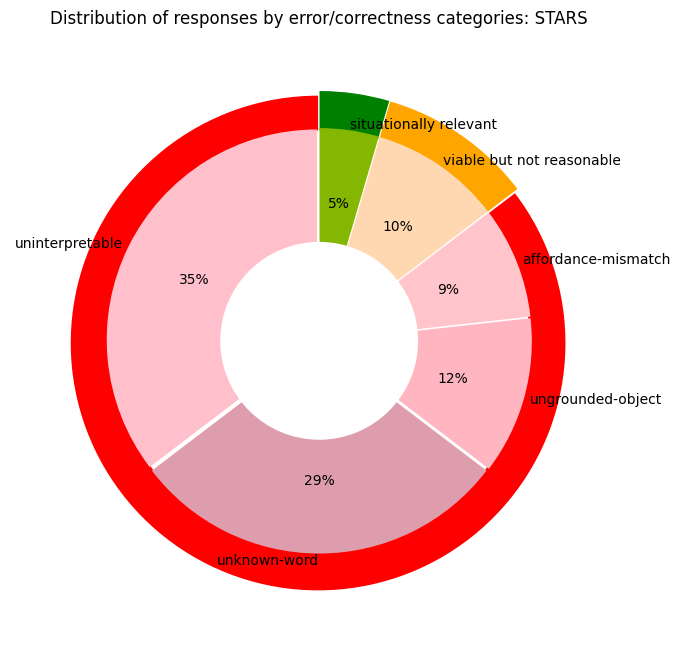

In [75]:
# Print out a single pie chart for the indicated condition
save_plot = True
#save_plot = False

single_condition = ["STARS"]

plot_title = experiment_name + "StandAloneResponseCategories" + ''.join(single_condition) 

categories = ['uninterpretable', 'unknown-word',  'ungrounded-object',  'affordance-mismatch', 'viable but not reasonable', 'embodiment limitation', 'post-completion error',
  'reasonable alternative location', 'situationally relevant']

color_dict = {'uninterpretable': 'pink',
              'unknown-word': 'xkcd:faded pink',
              'ungrounded-object': 'lightpink',
              'affordance-mismatch': 'xkcd:light rose',
              'viable but not reasonable': 'xkcd:light peach',
              'embodiment limitation': 'xkcd:creme',
              'post-completion error': 'lightgoldenrodyellow',
              'reasonable alternative location': 'xkcd:pale yellow',
              'situationally relevant': 'xkcd:dark lime'     }


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.tight_layout(pad=5)

# Dont care about i for single pie chart
i=0

condition = single_condition[0]
#    print(i,int(i/n_cols),i%n_cols)
category_df=summary[condition]
category_df = category_df.fillna(0)
    # print(category_df)    
process_response_summary_data(ax, category_df, condition, i)


if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


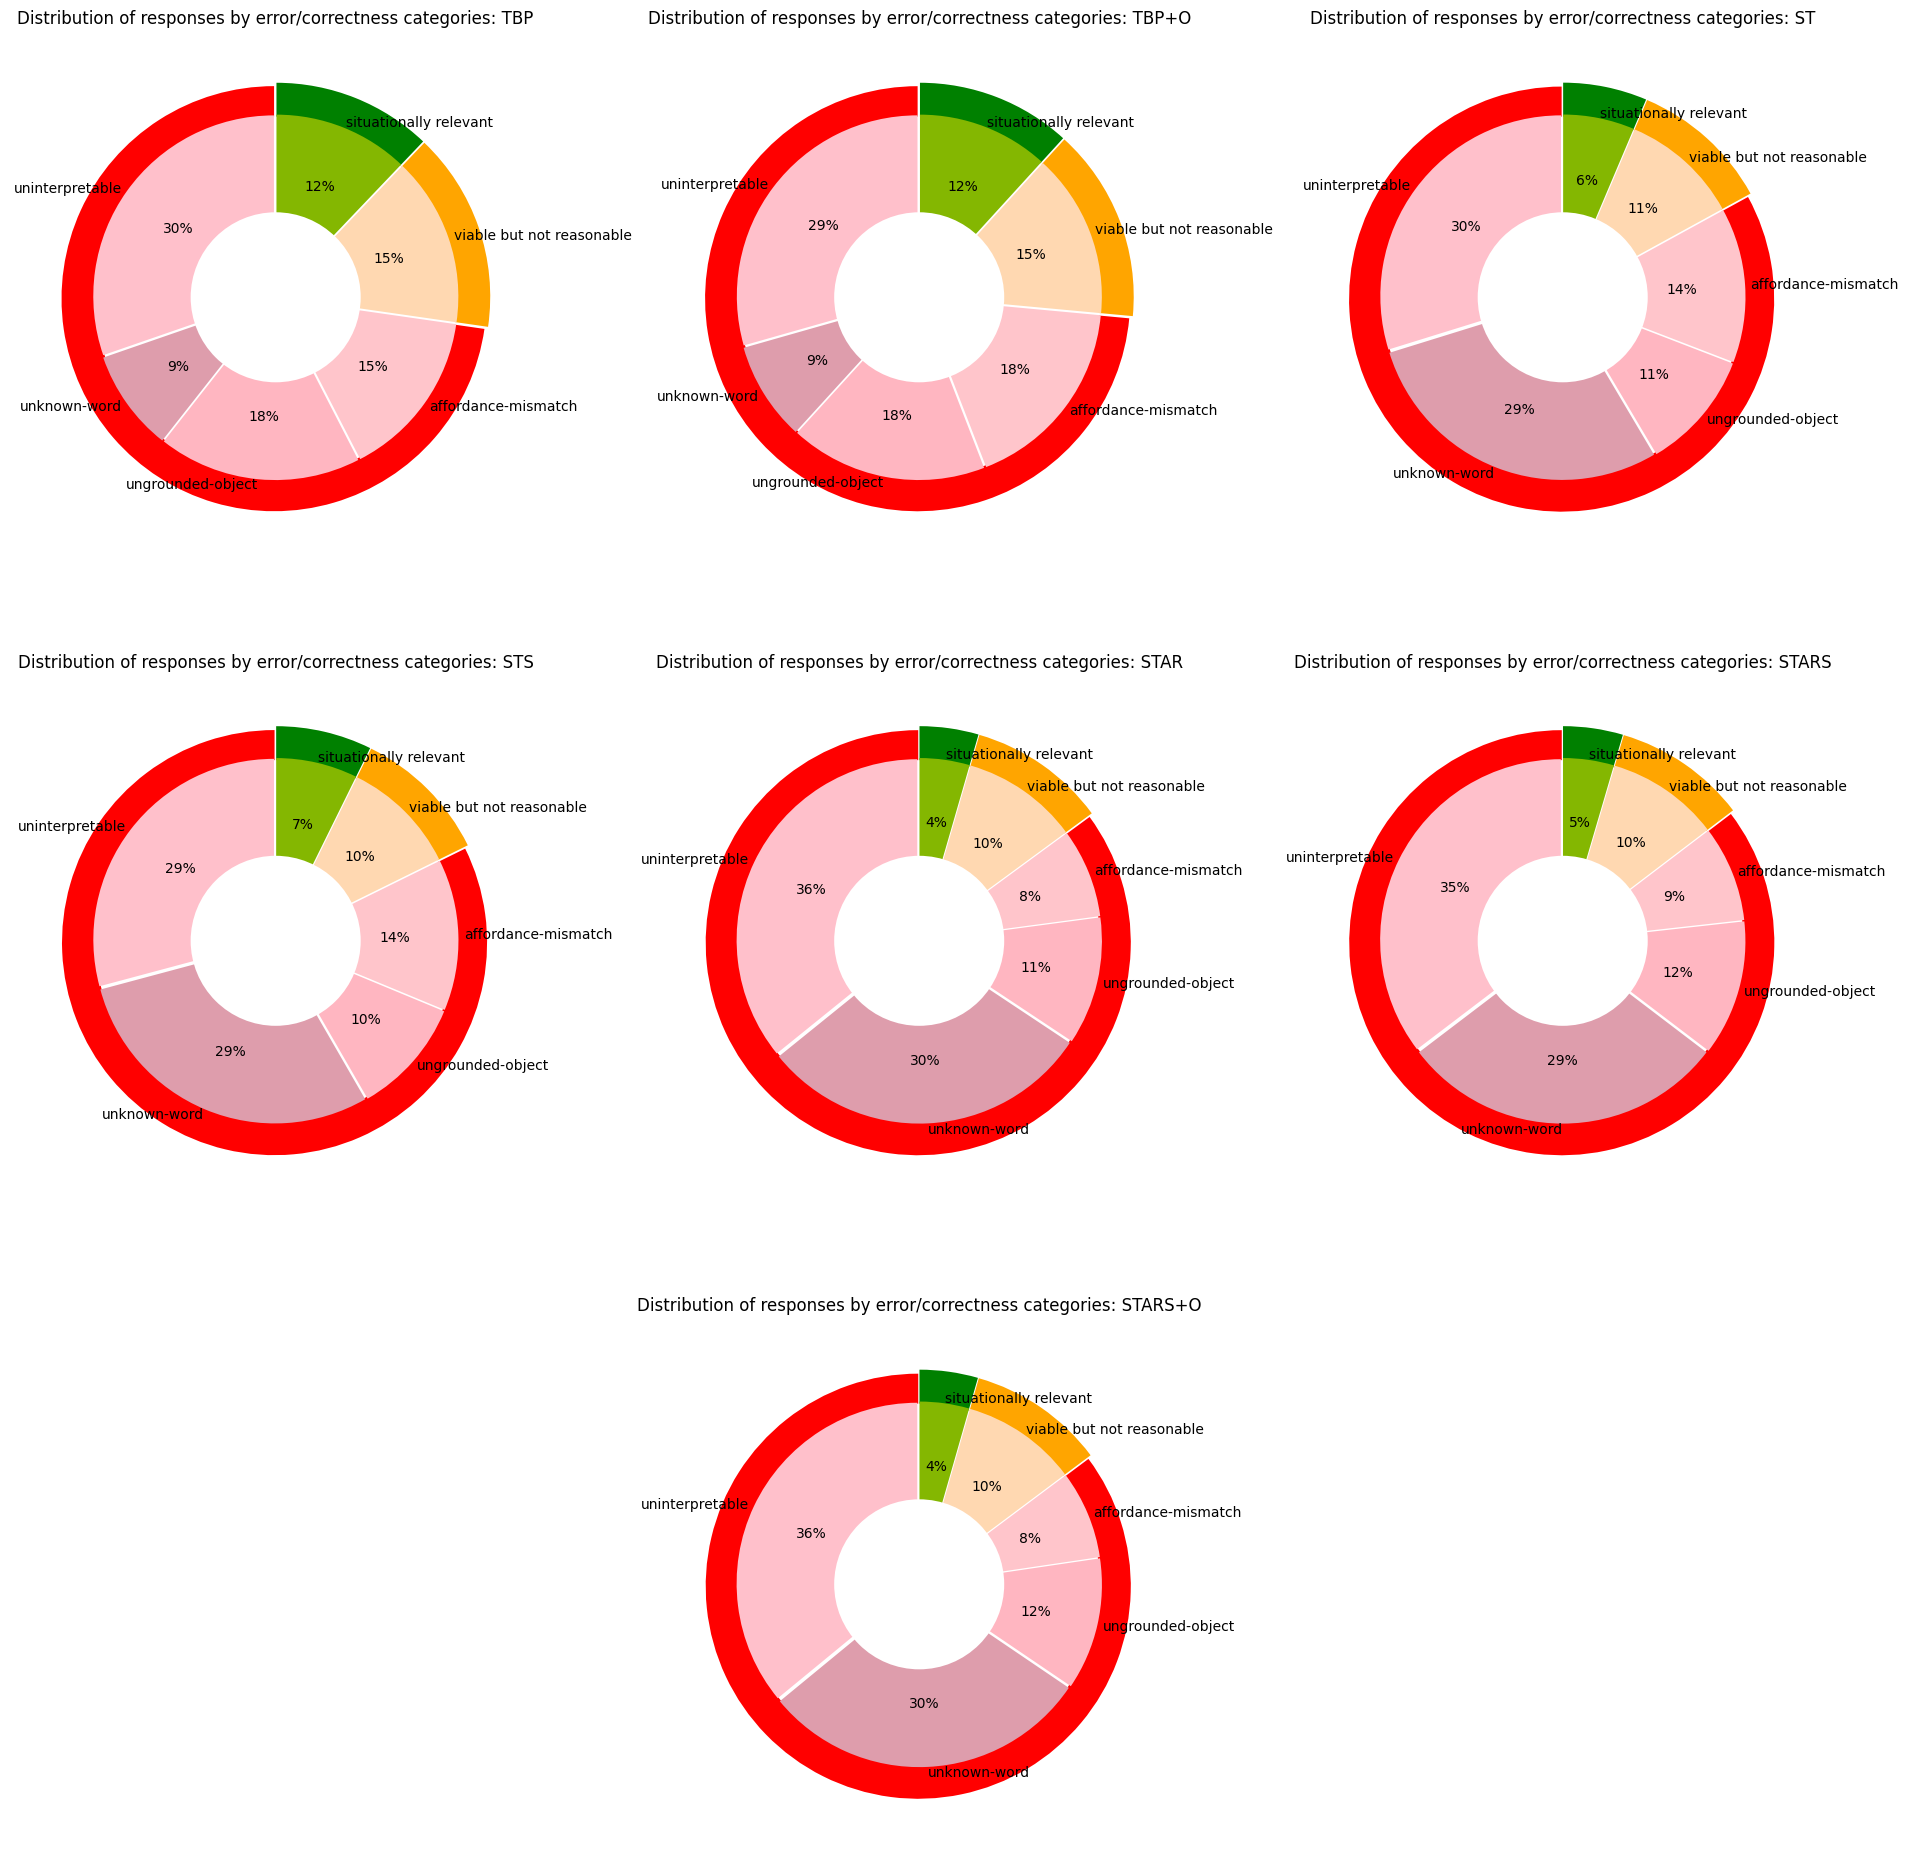

In [76]:
# Print out the pie charts in two horizontal rows
save_plot = True
#save_plot = False

plot_title = experiment_name + "ResponseCategories" + ''.join(condition_names) 

categories = ['uninterpretable', 'unknown-word',  'ungrounded-object',  'affordance-mismatch', 'viable but not reasonable', 'embodiment limitation', 'post-completion error',
  'reasonable alternative location', 'situationally relevant']

color_dict = {'uninterpretable': 'pink',
              'unknown-word': 'xkcd:faded pink',
              'ungrounded-object': 'lightpink',
              'affordance-mismatch': 'xkcd:light rose',
              'viable but not reasonable': 'xkcd:light peach',
              'embodiment limitation': 'xkcd:creme',
              'post-completion error': 'lightgoldenrodyellow',
              'reasonable alternative location': 'xkcd:pale yellow',
              'situationally relevant': 'xkcd:dark lime'     }


reverse_conditions = condition_names.copy()
reverse_conditions.reverse()

n_files = len(condition_names)
#print(n_files,condition_names)

n_rows =2
n_cols = int((n_files/n_rows)+.5)
#print(n_rows,n_cols)

# For STARS, customize to seven pie charts
n_rows =3
n_cols =3

fig, axes = plt.subplots(n_rows, n_cols , figsize=(20, 20))
fig.tight_layout(pad=5)


for i, condition in enumerate(reverse_conditions):
#    print(i,int(i/n_cols),i%n_cols)
    category_df=summary[condition]
    category_df = category_df.fillna(0)
    # print(category_df)    
    process_response_summary_data(axes[int(i/n_cols),i%n_cols], category_df, condition, i)

# Adjustments solely for inclusion in STARS paper
process_response_summary_data(axes[2,1], category_df, condition, i)
axes[2,0].remove()
axes[2,2].remove()
    

if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


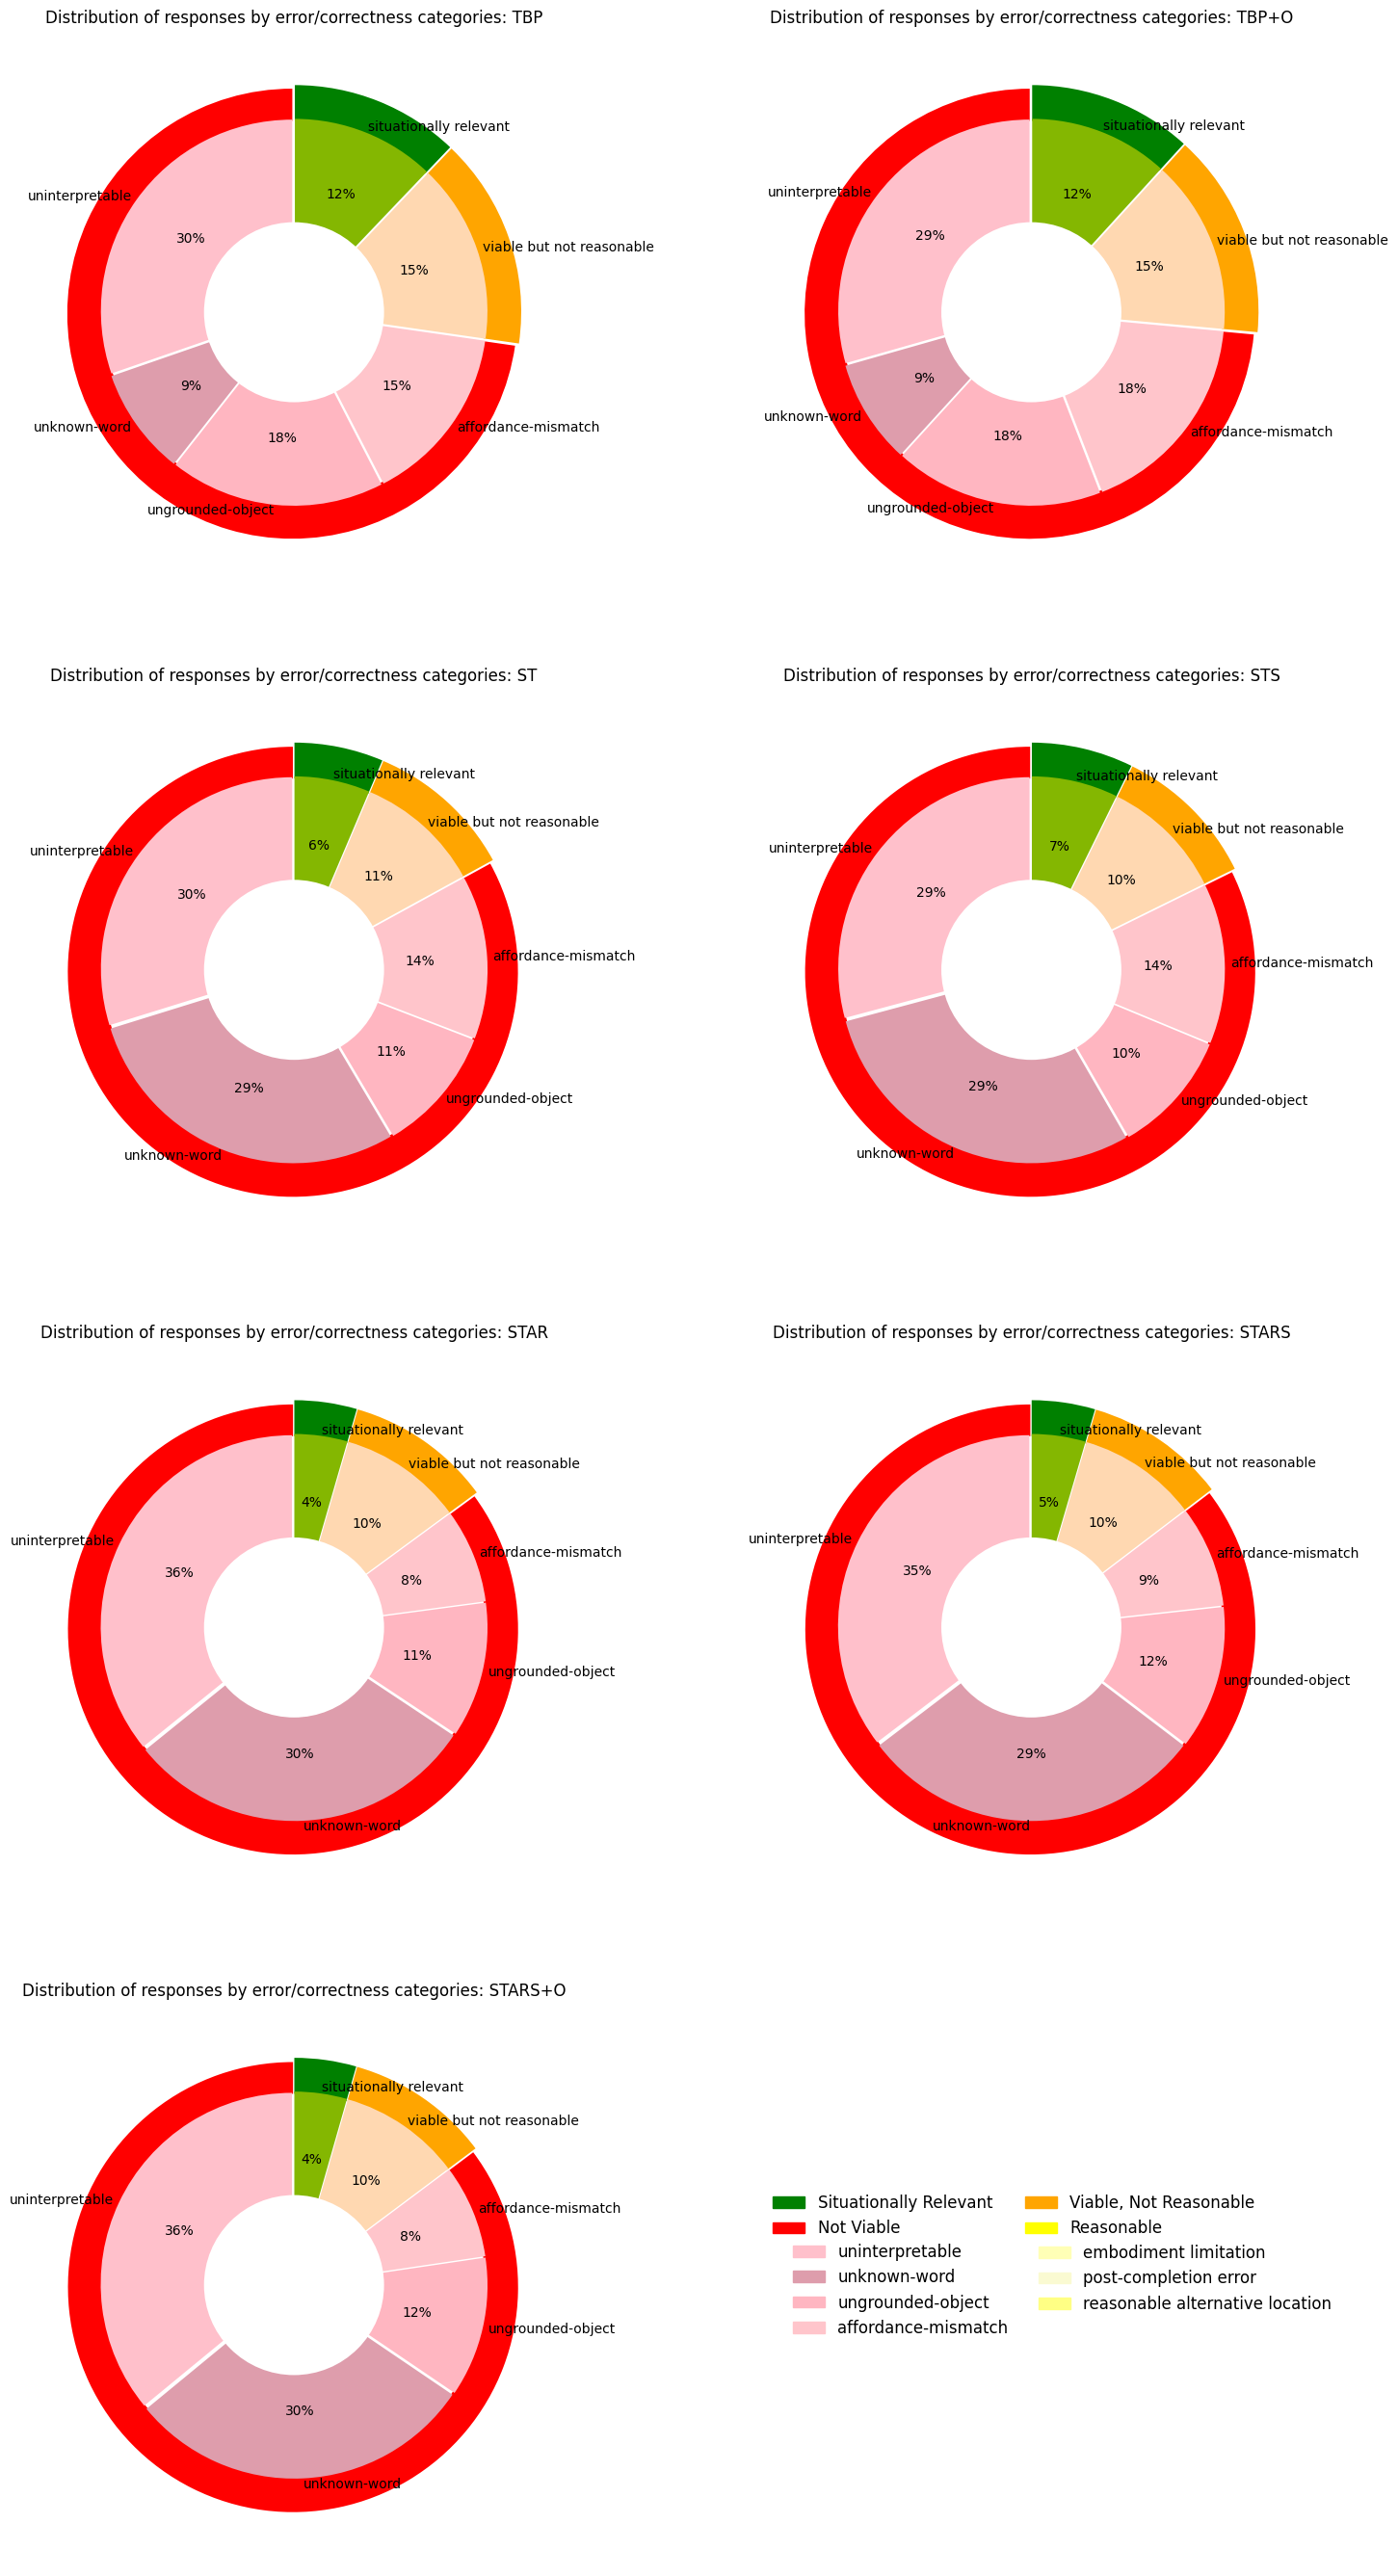

In [77]:
from matplotlib.patches import Patch 

# Print out the pie charts in two vertical columns
save_plot = True
#save_plot = False

plot_title = experiment_name + "ResponseCategoriesVertical" + ''.join(condition_names) 

categories = ['uninterpretable', 'unknown-word',  'ungrounded-object',  'affordance-mismatch', 
              'viable but not reasonable', 
              'embodiment limitation', 'post-completion error','reasonable alternative location', 
              'situationally relevant']

color_dict = {'uninterpretable': 'pink',
              'unknown-word': 'xkcd:faded pink',
              'ungrounded-object': 'lightpink',
              'affordance-mismatch': 'xkcd:light rose',
              'viable but not reasonable': 'xkcd:light peach',
              'embodiment limitation': 'xkcd:creme',
              'post-completion error': 'lightgoldenrodyellow',
              'reasonable alternative location': 'xkcd:pale yellow',
              'situationally relevant': 'xkcd:dark lime'     }


reverse_conditions = condition_names.copy()
reverse_conditions.reverse()

n_files = len(condition_names)
#print(n_files,condition_names)

n_cols = 2
n_rows = int((n_files/n_cols)+.5)

#print(n_rows,n_cols)

fig, axes = plt.subplots(n_rows, n_cols , figsize=(16, 28))
fig.tight_layout(pad=5)


col = 0
row = 0 
for i, condition in enumerate(reverse_conditions):
#    print(i,int(i/n_cols),i%n_cols)
    category_df=summary[condition]
    category_df = category_df.fillna(0)
    # print(category_df)
    # Hack to print out in the desired order
    process_response_summary_data(axes[row,col], category_df, condition, i)
    if col == 0:
        col += 1
    else:
        col = 0
        row += 1

axes[n_rows-1,1].remove()

# Put the legend in the blank position for the CORL paper

offset = .025
legend_ax = fig.add_axes([0.8,0.125+offset, 0.1, 0.1]) 

unviable = Patch(color="red")
not_reasonable = Patch(color="orange")
reasonable=Patch(color="yellow")
sit_rel= Patch(color="green")
legend_ax.legend(labels=['Situationally Relevant','Not Viable', 'Viable, Not Reasonable', 'Reasonable'], 
                  handles=[sit_rel,unviable,not_reasonable,reasonable],loc=4,fontsize=12,ncols=2, frameon=False)
legend_ax.axis('off')


legend_ax2 = fig.add_axes([0.64,0.088+offset, 0.1, 0.1]) 
patches =[]

for i, category in enumerate(categories):
    patches.append(Patch(color=color_dict[category]))

legend_ax2.legend(labels=categories[0:4], 
                  handles=patches[0:4],loc=4,fontsize=12,ncols=1,frameon=False)
legend_ax2.axis('off')


legend_ax3 = fig.add_axes([0.85,0.097+offset, 0.1, 0.1]) 
legend_ax3.legend(labels=categories[5:8], 
                  handles=patches[5:8],loc=4,fontsize=12,ncols=1,frameon=False)
legend_ax3.axis('off')


if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


NameError: name 'pie_colors' is not defined

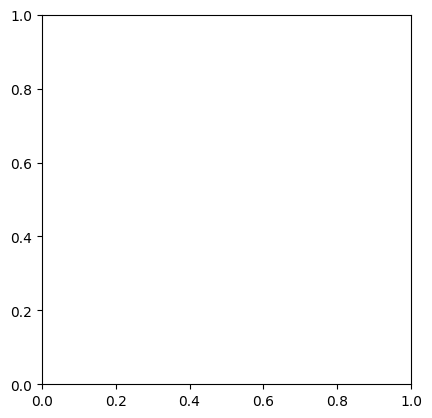

In [82]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')

wedges, texts, percs = ax.pie(category_df.values, labels=category_df.index, colors=pie_colors, autopct='%1.0f%%', labeldistance=1.1, startangle=90)

groups = [[0, 1, 2, 3], [4], [5, 6, 7], [8]]
radfraction = 0.1
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
ax.autoscale(True)
plt.show()

Data set: OfficeTask


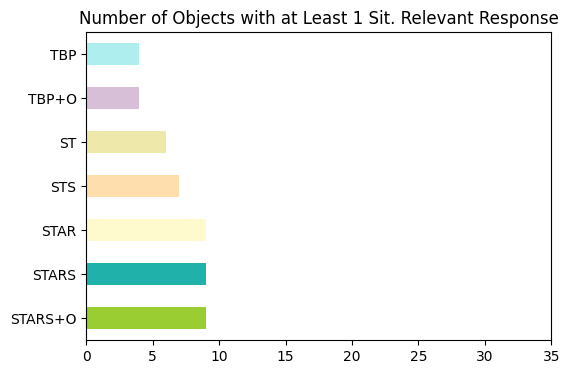

STARS+O 9
STARS 9
STAR 9
STS 7
ST 6
TBP+O 4
TBP 4


In [83]:
# Percentage of responses that are situationally relevant

save_plot = True
#save_plot = False
plot_title = experiment_name + "situationally_relevant_responses" + '_'.join(condition_names)

bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
#bar_colors = ["plum", "powderblue", "palegoldenrod", "navajowhite", "yellowgreen"]

#human_conditions = ["lm_human","lm_human_tree","lm_human_tree_select","lm_human_tree_eval","lm_human_tree_eval_select"]
#human_conditions = ["lm_human","lm_human_tree_eval_select"]
#human_conditions = []
#human_conditions.reverse()
#human_bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle"]
#human_bar_colors.reverse()

bar_colors.reverse()

fig, ax = plt.subplots( figsize=(6,4))

#summary.loc["situationally relevant"].div(len(gold_data[gold_data.gold_relation != "is-open1"])).plot(kind="barh", ax=axes[0,0],title="Objects with at Least 1 Sit. Relevant Response",color=bar_colors,xlim={0,1})
object_summary["value"].plot(kind="barh", ax=ax, title="Number of Objects with at Least 1 Sit. Relevant Response",color=bar_colors,xlim={0,35})


print("Data set:", experiment_name)

if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')

plt.show()

for condition in condition_names:
    print(condition, object_summary.at[condition,"value"])


    

Data set: OfficeTask


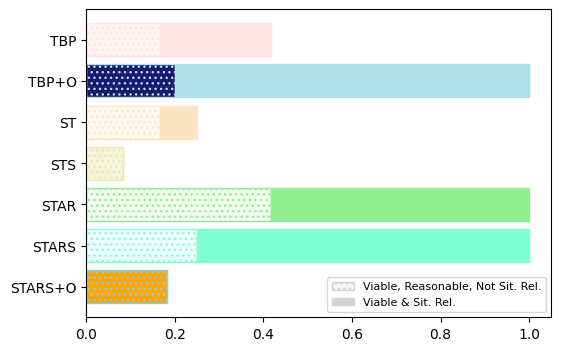

STARS+O 0
STARS 1.0
STAR 1.0
STS 0.08333333333333333
ST 0.25
TBP+O 1.0
TBP 0.4166666666666667


In [84]:
# Percentage of responses that are at least reasonable (even if not sit relevant or have some minor issue)
from matplotlib.patches import Patch 


save_plot = True
#save_plot = False
plot_title = experiment_name + "at_least_reasonable_responses" + '_'.join(condition_names)

bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
#bar_colors = ["plum", "powderblue", "palegoldenrod", "navajowhite", "yellowgreen"]
bar_colors = ["mistyrose",
              "powderblue",  
              "bisque", "palegoldenrod", "lightgreen", "aquamarine",
              "skyblue"]
bar_colors.reverse()

comp_bar_colors = ["darkblue",  "midnightblue", "purple", "cadetblue", "mediumorchid", "darkgoldenrod", "orange", "darkkhaki", "mediumaquamarine", "olive"]
comp_bar_colors = ["seashell",  "midnightblue", "floralwhite", "beige", "honeydew", "azure", "orange"]
comp_bar_colors.reverse()

#human_conditions = ["lm_human","lm_human_tree","lm_human_tree_select","lm_human_tree_eval","lm_human_tree_eval_select"]
#human_conditions = ["lm_human","lm_human_tree_eval_select"]
#human_conditions = []
#human_conditions.reverse()
#human_bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle"]
#human_bar_colors.reverse()
human_conditons = ["TBP+Oversight","STARS+O"]

for condition in human_conditons:
    object_summary.at[condition,"frac_reas"] = 0
    object_summary.at[condition,"sit_rel_only"] = 0
    object_summary.at[condition,"frac_rel_only"] = 0

fig, ax = plt.subplots( figsize=(6,4))

#summary.loc["situationally relevant"].div(len(gold_data[gold_data.gold_relation != "is-open1"])).plot(kind="barh", ax=axes[0,0],title="Objects with at Least 1 Sit. Relevant Response",color=bar_colors,xlim={0,1})
#object_summary["frac_reas"].plot(kind="barh", ax=ax, title="Fraction of Used Responses Reasonable/Sit. Relevant",color=bar_colors,xlim={0,1})

ax.barh(object_summary.index, object_summary['frac_reas_only'],  label='Viable, Reasonable, Not Sit. Rel.', 
        color=comp_bar_colors, edgecolor=bar_colors, hatch=['...'])
ax.barh(object_summary.index, object_summary['sit_rel_only'],  left=object_summary['frac_reas_only'], 
        label='Viable & Sit. Rel.', color=bar_colors,  edgecolor=bar_colors)

rea = Patch(color="whitesmoke")

rea.set_edgecolor("lightgray")
rea.set_hatch('...')
sit = Patch(color="lightgray")
ax.legend(labels=['Viable, Reasonable, Not Sit. Rel.', 'Viable & Sit. Rel.'], handles=[rea,sit],loc=4,fontsize=8)




print("Data set:", experiment_name)

if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')

plt.show()

for condition in condition_names:
    print(condition, object_summary.at[condition,"frac_reas"])


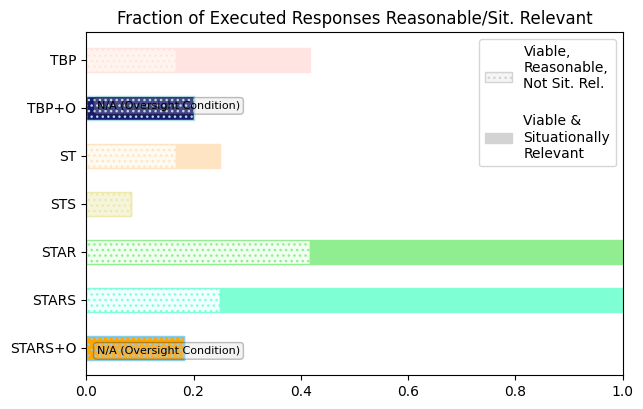

In [85]:
# Final version (Adapted to include either both object and at least relevant or just at least relevant)
# Percentage of responses that are situationally relevant
from matplotlib.patches import Patch 

save_plot = True
#save_plot = False
both_plots = True
both_plots = False

if both_plots == True:
    plot_title = experiment_name + "FractionObjectsAndSituationallyRelevantAndReasonableResponses" + '_'.join(condition_names)
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=True)
else: 
    plot_title = experiment_name + "SituationallyRelevantAndReasonableResponsesOnly" + '_'.join(condition_names)
    # Use for a stand-alone version of the fractional plot
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
fig.tight_layout(pad=1)
    
bar_colors = ["mistyrose",
              "powderblue",  
              "bisque", "palegoldenrod", "lightgreen", "aquamarine",
              "skyblue"]

bar_colors.reverse()
comp_bar_colors = ["darkblue",  "midnightblue", "purple", "cadetblue", "mediumorchid", "darkgoldenrod", "orange", "darkkhaki", "mediumaquamarine", "olive"]
comp_bar_colors = ["seashell",  "midnightblue", "floralwhite", "beige", "honeydew", "azure", "orange"]
comp_bar_colors.reverse()

#summary.loc["situationally relevant"].div(len(gold_data[gold_data.gold_relation != "is-open1"])).plot(kind="barh", ax=axes[0,0],title="Objects with at Least 1 Sit. Relevant Response",color=bar_colors,xlim={0,1})
object_summary["value"].plot(kind="barh", ax=ax[0], title="Number of Objects with >= 1 Situationally Relevant Resp.",color=bar_colors,xlim={0,35})
#print("Data set:", experiment_name)

human_conditions = ["TBP+O","STARS+O"]

for condition in human_conditions:
    object_summary.at[condition,"frac_reas"] = 0
    object_summary.at[condition,"sit_rel_only"] = 0
    object_summary.at[condition,"frac_rel_only"] = 0
    # Some odd issue with counting situationally relevant for human conditions 
    object_summary.at[condition,"value"] = 35

#fig, ax = plt.subplots( figsize=(6,4))

#summary.loc["situationally relevant"].div(len(gold_data[gold_data.gold_relation != "is-open1"])).plot(kind="barh", ax=axes[0,0],title="Objects with at Least 1 Sit. Relevant Response",color=bar_colors,xlim={0,1})
#object_summary["frac_reas"].plot(kind="barh", ax=ax, title="Fraction of Used Responses Reasonable/Sit. Relevant",color=bar_colors,xlim={0,1})

ax[1].barh(object_summary.index, object_summary['frac_reas_only'],  label='Viable, Reasonable, Not Sit. Rel.', 
        color=comp_bar_colors, edgecolor=bar_colors, hatch=['...'], height=.5)
ax[1].barh(object_summary.index, object_summary['sit_rel_only'],  left=object_summary['frac_reas_only'], 
        label='Viable & Sit. Rel.', color=bar_colors,  edgecolor=bar_colors, height=.5)

rea = Patch(color="whitesmoke")

rea.set_edgecolor("lightgray")
rea.set_hatch('...')
sit = Patch(color="lightgray")
ax[1].legend(labels=['Viable,\nReasonable,\nNot Sit. Rel.\n', 'Viable &\nSituationally\nRelevant'], 
             handles=[rea,sit],fontsize=10,loc="upper right",
             frameon=True)
ax[1].set_title("Fraction of Executed Responses Reasonable/Sit. Relevant")
ax[1].set_xlim([0,1])

# Annotate the seemingly missing oversight conditions
human_bar_colors = ["powderblue", "skyblue"]
human_bar_colors.reverse()
props = dict(boxstyle='round', facecolor="lightgray", alpha=0.25)
ax[1].text(0.02, 5.6/7, "N/A (Oversight Condition)", transform=ax[1].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
props = dict(boxstyle='round', facecolor="lightgray", alpha=0.25)
ax[1].text(0.02, .6/7, "N/A (Oversight Condition)", transform=ax[1].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

if both_plots == False:
    # Use to remove the objects
    ax[0].remove()


if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')

plt.show()

#for condition in condition_names:
#    print(condition, object_summary.at[condition,"value"])